# Train MobileV2 for Plantas50
Short example of finetuning the MobileV2 model trained in the ImageNet dataset for Plantas50

In [1]:
import tensorflow as tf
import numpy as np
import os.path

from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

import matplotlib.pyplot as plt

### Download the Plantas50
- Download the Plantas50 dataset by using our [Downloader](https://github.com/reneoctavio/plantas/raw/master/download_plantas50.py)
- Prepare your TFRecords using our [script](https://github.com/reneoctavio/plantas/raw/master/prepare_tfrecord_plantas50.py)

Then execute them:

- `python download_plantas50.py /path/to/dir`
- `python prepare_tfrecord_plantas50.py /path/to/Plantas50`

In [2]:
# Files for the TFRecords and labels file
train_file  = os.path.expanduser('~/Projects/Datasets/Plantas50/Plantas50_train.tfrecord')
valid_file  = os.path.expanduser('~/Projects/Datasets/Plantas50/Plantas50_valid.tfrecord')
test_file   = os.path.expanduser('~/Projects/Datasets/Plantas50/Plantas50_test.tfrecord')
labels_file = os.path.expanduser('~/Projects/Datasets/Plantas50/labels-ids.txt')

In [3]:
# Dictionary that will map labels to ids
labels_to_ids = {}
ids_to_labels = {}
with open(labels_file, 'r') as f:
    for l in f.readlines():
        name, idx = l.strip().split(',')
        labels_to_ids[name] = int(idx)
        ids_to_labels[int(idx)] = name

In [4]:
# Set some project constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 48
EPOCHS = 10
IMAGE_SIZE = 224
NUM_LABELS = 50
NUM_PARALLEL_CALLS = 4
NUM_TRAINING_IMAGES = 26669
NUM_VALIDATION_IMAGES = 3333
NUM_TEST_IMAGES = 3335
SHUFFLE_BUFFER = 1000
STEPS_PER_EPOCH = int(np.ceil(NUM_TRAINING_IMAGES / BATCH_SIZE))

## Preprocessing images
For evaluation we take a central crop and resize.

For training we take a random crop, resize, randomly flip and randomly distort.
Images must be in range -1 to 1.

The images were saved as JPEG, thus we have to decode it before preprocessing.

We also create a one-hot vector of the label.

In [5]:
def _preprocess_image(image, size, is_training=False):
    # Range [0, 1]
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    # Evaluation
    if not is_training:
        image = tf.image.central_crop(image, central_fraction=0.875)
        image = tf.image.resize_images(image, size)
    else:
        # Get random part of image
        bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
        bbegin, bsize, bbox = tf.image.sample_distorted_bounding_box(tf.shape(image), 
                                                                     bbox, 
                                                                     min_object_covered=0.75,
                                                                     aspect_ratio_range=[0.75, 1.33],
                                                                     area_range=[0.75, 1.],
                                                                     max_attempts=100,
                                                                     use_image_if_no_bounding_boxes=True)
        image = tf.slice(image, bbegin, bsize)
        image.set_shape([None, None, 3])
        image = tf.image.resize_images(image, size)

        # Random flip
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)

        # Random distort
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    
    # Range [-1, 1]
    image = tf.multiply(image, 2.0)
    image = tf.subtract(image, 1.0)
    
    # Make sure is within range
    image = tf.clip_by_value(image, -1.0, 1.0)
    
    return image

    
def _parse_function(example, img_size, num_labels, is_training=False):
    # Description of the data
    feature_description = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/class/label': tf.FixedLenFeature([], tf.int64, default_value=tf.zeros([], dtype=tf.int64))
    }
       
    # Extract example
    example = tf.parse_single_example(example, feature_description)
    image = tf.cast(tf.image.decode_jpeg(example['image/encoded'], channels=3), dtype=tf.uint8)
    label = example['image/class/label']
    
    # Preprocess image
    image = _preprocess_image(image, img_size, is_training=is_training)
    label = tf.one_hot(label, num_labels)
    
    return image, label

In [6]:
# Create a dataset object ready for use
def create_dataset(filepath, batch_size, img_size, num_labels, is_training=False):
    
    _map = lambda example: _parse_function(example, img_size, num_labels, is_training=is_training)
    dataset = tf.data.TFRecordDataset(filepath)
    dataset = dataset.map(_map, num_parallel_calls=NUM_PARALLEL_CALLS)
    dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER).repeat()
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

## Model
We will read the MobileV2 model with ImageNet weights and then create a classification module in order to finetune our model for Plantas50.

In this example we will train the whole model. The output of the Dense layer have the size of the number of species.

In [7]:
# Load Base model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all Base model layers
for layer in base_model.layers:
    layer.trainable = True

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Create the classification module
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(320, activation='relu')(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.Dense(NUM_LABELS, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=8e-5, nesterov=True),
              metrics=['acc', keras.metrics.top_k_categorical_accuracy])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                 

In [9]:
# SGD Scheduler (Decrease from 0.1 to 0.0001 per epoch)
def schedule(epoch, lr):
    return lr * 10**(-3./(EPOCHS))
    
# Callback to save model
callbacks = [keras.callbacks.ModelCheckpoint('mobile_v2_plantas50_weights.{epoch:02d}-{val_acc:.2f}.hdf5', 
                                             save_best_only=True),
             keras.callbacks.LearningRateScheduler(schedule, verbose=1)
            ]

# Create dataset objects for training and validation
train_dataset = create_dataset(train_file, BATCH_SIZE, [IMAGE_SIZE, IMAGE_SIZE], NUM_LABELS, is_training=True)
valid_dataset = create_dataset(valid_file, BATCH_SIZE, [IMAGE_SIZE, IMAGE_SIZE], NUM_LABELS, is_training=False)

# Train the model
history = model.fit(train_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    epochs = EPOCHS,
                    callbacks=callbacks,
                    validation_data = valid_dataset,
                    validation_steps = int(np.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE)),
                    verbose = 1)

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0501187241095544.
Epoch 1/10
556/556 [==============================] - 273s 492ms/step - loss: 2.5064 - acc: 0.3246 - top_k_categorical_accuracy: 0.6525 - val_loss: 8.6151 - val_acc: 0.0161 - val_top_k_categorical_accuracy: 0.1396

Epoch 00002: LearningRateScheduler reducing learning rate to 0.02511886550999774.
Epoch 2/10
556/556 [==============================] - 255s 459ms/step - loss: 1.5781 - acc: 0.5468 - top_k_categorical_accuracy: 0.8503 - val_loss: 4.8091 - val_acc: 0.0902 - val_top_k_categorical_accuracy: 0.2973

Epoch 00003: LearningRateScheduler reducing learning rate to 0.012589254497656858.
Epoch 3/10
556/556 [==============================] - 255s 458ms/step - loss: 1.0426 - acc: 0.6888 - top_k_categorical_accuracy:

## Training analysis

Finetuning seems to be working and with little overfitting.

But you can always change settings to improve a little bit. 

You should feel free to change the classification and then verify the changes. You can:

- Add and remove layers, and change their output size
- Add and remove dropouts or change their rate
- Add other regularizations
- Add auxiliary classifiers throughout the network
- Train only the last layer
- Change optimizers and learning policy
- Increase number of epochs

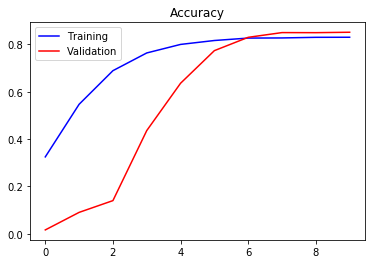

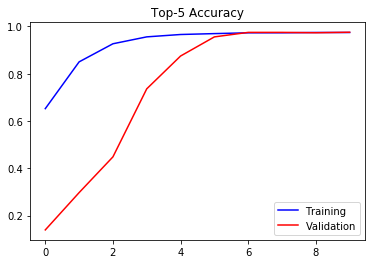

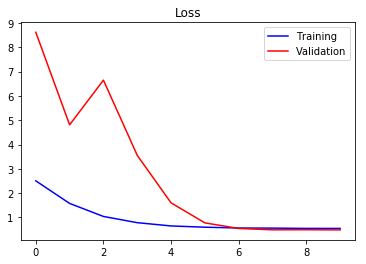

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
top5_acc = history.history['top_k_categorical_accuracy']
val_top5_acc = history.history['val_top_k_categorical_accuracy']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, top5_acc, 'b', label='Training')
plt.plot(epochs, val_top5_acc, 'r', label='Validation')
plt.title('Top-5 Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

## Evaluation
Let's see how our model will do with out test set.

First we will verify the accuracy and top-5 accuracy of the test set, then we will take some image examples from the test set and predict their species.

The test set accuracy is 85.57% and top-5 accuracy is 97.74%. 

There is room for improvements. In our paper, the best model gave 94.6% accuracy and 99.2% top-5 accuracy.

In [11]:
# Evaluation
test_dataset = create_dataset(test_file, BATCH_SIZE, [IMAGE_SIZE, IMAGE_SIZE], NUM_LABELS, is_training=False)

out = model.evaluate(test_dataset, 
                     batch_size=BATCH_SIZE, 
                     verbose=1, 
                     steps=int(np.ceil(NUM_TEST_IMAGES / BATCH_SIZE)))

70/70 [==============================] - 6s 82ms/step - loss: 0.4887 - acc: 0.8557 - top_k_categorical_accuracy: 0.9774


In [12]:
# Predict for a batch of test images
test_iter = test_dataset.make_one_shot_iterator()
images, labels = test_iter.get_next()

sess = tf.keras.backend.get_session()
images, labels = sess.run([images, labels])

In [13]:
images = images[:8]
labels = labels[:8]
preds = model.predict(images)
preds = np.argmax(preds, axis=1)
labels = np.argmax(labels, axis=1)
preds, labels

(array([46, 29, 35, 45, 13, 42, 24, 45]),
 array([46, 29, 35, 45, 13, 42, 12, 45]))

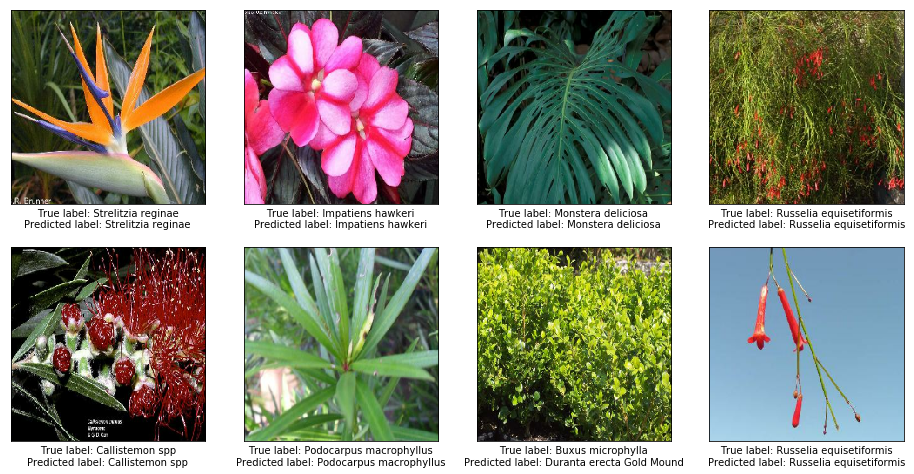

In [14]:
# Put images in [0,1] range for plotting
images = (images + 1.) / 2.
images = np.clip(images, 0., 1.)

plt.figure(figsize=(16,8))
for n, image, label, pred in zip(range(len(labels)), images, labels, preds):
    plt.subplot(2, 4, n + 1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('True label: {}\nPredicted label: {}'.format(ids_to_labels[label],
                                                            ids_to_labels[pred]))

### Citation
If the Plantas50 database was useful in your publications, please cite:

    @inproceedings{plantas-db-2016,
    author={Dias, Ren{\'e} Octavio Queiroz and Borges, D{\'i}bio Leandro},
    booktitle={2016 IEEE International Symposium on Multimedia (ISM)},
    title={Recognizing Plant Species in the Wild: Deep Learning Results and a New Database},
    year={2016},
    pages={197-202},
    doi={10.1109/ISM.2016.0047},
    isbn={978-1-5090-4571-6/16},
    url={https://doi.org/10.1109/ISM.2016.0047},
    month={Dec},}

### Legal
- Plantas50Basic and Plantas50Extra by René Octavio Queiroz Dias are licensed under a Creative Commons Attribution 4.0 International License.

- Some images of Plantas50Internet subset may have copyright. Training and using recognition model for research or non-commercial use may constitute fair use of data.

- All code is under MIT license, unless stated otherwise in the header of the code.